##Deep Learning - Project 2 Miscallibration study

Group members:

- Juan Muñoz Villalón

- Elena Almagro Azor

- Mario Golbano Corzo

In [2]:
from google.colab import drive
drive.mount("/content/drive") # Don't change this.


Mounted at /content/drive


In [3]:
import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time
import os
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, random_split

In [4]:
# FILE/FOLDER PATHS
my_path = "Project_II_DL" #
my_path = "Master_Salud/DeepLearning/Project_II_DL/"
my_path = "MLfH/1c/DL/Project_II_DL/"
gdrive_path = "/content/drive" + "/My Drive/" + my_path
os.chdir(gdrive_path)

# To check the current path
!pwd
!ls

/content/drive/.shortcut-targets-by-id/1WQH3kKQwzCCKwuL2VW4z1vN9s_tPp9-G/Project_II_DL
 1706.04599v2.pdf		      Lenet5_extended_GPU_Drop.pth
 bien_supuestamente.ipynb	      Lenet5_Temperature_1_extended.pth
 Code.ipynb			      Lenet5_Temperature_extended.pth
'Copia de bien_supuestamente.ipynb'   Project2_DL.ipynb
 data				      Project2_DL_version2.ipynb


In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset

# Define image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download CIFAR-10
full_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Bird class and cat class indexes
classes = ('bird', 'cat')
class_indices = [2, 3]  # 2 for birds and 2 for cats

def filter_and_relabel(dataset, class_indices):
    targets = torch.tensor(dataset.targets)
    mask = torch.isin(targets, torch.tensor(class_indices))
    indices = torch.where(mask)[0]

    # Filer dataset and change labels
    subset = Subset(dataset, indices)
    for idx in range(len(subset)):
        label = subset.dataset.targets[indices[idx].item()]
        subset.dataset.targets[indices[idx].item()] = 0 if label == 2 else 1  # 2 -> 0 (birds), 3 -> 1 (cats)
    return subset

# Make subsets for training and test with only cats and birds
trainset = filter_and_relabel(full_trainset, class_indices)
testset = filter_and_relabel(full_testset, class_indices)

# Divide train set in training subset and val subset
train_size = int(0.8 * len(trainset))
valid_size = len(trainset) - train_size
train_subset, valid_subset = random_split(trainset, [train_size, valid_size])

# Create DataLoaders
trainloader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
validloader = DataLoader(valid_subset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

print(f"Train size: {len(train_subset)}, Validation size: {len(valid_subset)}, Test size: {len(testset)}")


Files already downloaded and verified
Files already downloaded and verified
Train size: 8000, Validation size: 2000, Test size: 2000


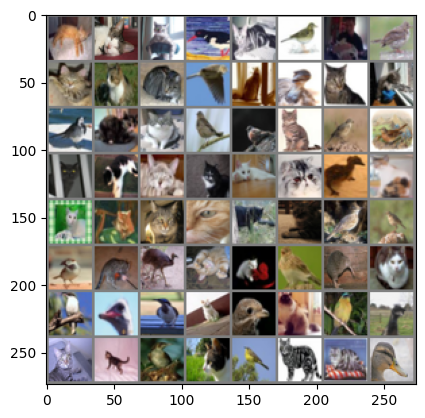

tensor([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0])


In [6]:
# Obtain images and labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(utils.make_grid(images))
print(labels)

In [7]:
import torch.nn as nn

class Lenet5_Drop(nn.Module):
    def __init__(self, dimx, prob, nlabels):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)

        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Linear layers
        self.linear1 = nn.Linear(400, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, 1)

        # Activations and Dropout
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()  # Añadimos Sigmoid para salida binaria
        self.dropout = nn.Dropout(p=prob)
        self.logsoftmax = nn.LogSoftmax(dim=1)

        # Batch Normalization
        self.BN_1 = nn.BatchNorm2d(num_features=6)
        self.BN_2 = nn.BatchNorm2d(num_features=16)
        self.BN_3 = nn.BatchNorm1d(120)

        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx - 4) / 2 - 4) / 2)

    def forward(self, x):
        # Pass through the first conv block
        x = self.conv1(x)
        #x = self.BN_1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Pass through the second conv block
        x = self.conv2(x)
        #x = self.BN_2(x)
        x = self.relu(x)
        x = self.pool(x)
        #x = self.dropout(x)

        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 16 * self.final_dim**2)

        # Pass through fully connected layers
        x = self.linear1(x)
        #x = self.BN_3(x)
        x = self.relu(x)
        #x = self.dropout(x)

        x = self.linear2(x)
        x = self.relu(x)
        #x = self.dropout(x)

        x = self.linear3(x)
        x = self.sigmoid(x)
        return x


    def forward_logit(self, x):
        # Pass through the first conv block
        x = self.conv1(x)
        #x = self.BN_1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Pass through the second conv block
        x = self.conv2(x)
        #x = self.BN_2(x)
        x = self.relu(x)
        x = self.pool(x)
        #x = self.dropout(x)

        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 16 * self.final_dim**2)

        # Pass through fully connected layers
        x = self.linear1(x)
        #x = self.BN_3(x)
        x = self.relu(x)
        #x = self.dropout(x)

        x = self.linear2(x)
        x = self.relu(x)
        #x = self.dropout(x)

        x = self.linear3(x)
        return x



In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

class Lenet5_extended_GPU_Drop(Lenet5_Drop):

    def __init__(self, dimx, prob, nlabels, epochs=100, lr=0.001):
        super().__init__(dimx, prob, nlabels)

        self.lr = lr  # Learning Rate
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.BCELoss()

        # Lists to save loss evolution during training and validation
        self.loss_during_training = []
        self.valid_loss_during_training = []

        # Config device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def trainloop(self, trainloader, validloader):
        # Optimization loop
        for e in range(int(self.epochs)):
            start_time = time.time()
            running_loss = 0.

            for images, labels in trainloader:
                # Data to device
                images, labels = images.to(self.device), labels.to(self.device).float()

                # Reset grad
                self.optim.zero_grad()

                # Forward pass
                out = self.forward(images)

                # Calculate loss
                loss = self.criterion(out.squeeze(), labels)
                running_loss += loss.item()

                # Backward passand and optim
                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss / len(trainloader))

            # Calculate val loss
            with torch.no_grad():
                self.eval()
                running_loss = 0.

                for images, labels in validloader:
                    images, labels = images.to(self.device), labels.to(self.device).float()
                    out = self.forward(images)
                    loss = self.criterion(out.squeeze(), labels)
                    running_loss += loss.item()

                self.valid_loss_during_training.append(running_loss / len(validloader))

            # Back to train mode
            self.train()

            #Print each epoch
            if e % 1 == 0:
                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" %
                      (e, self.loss_during_training[-1], self.valid_loss_during_training[-1],
                       (time.time() - start_time)))

    def eval_performance(self, dataloader):
        correct_predictions = 0
        total_samples = 0
        self.eval()

        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(self.device), labels.to(self.device).float()

                probs = self.forward(images).squeeze()

                # Binary classification: turn probs in predictions (0/1)
                predictions = (probs > 0.5).float()

                # Number of correct predictions
                correct_predictions += (predictions == labels).sum().item()
                total_samples += labels.size(0)

        # Accuracy
        accuracy = correct_predictions / total_samples

        self.train()
        return accuracy

In [14]:
my_CNN_GPU_Drop = Lenet5_extended_GPU_Drop(dimx=32,prob=0.5,epochs=15,lr=1e-3, nlabels=1)
my_CNN_GPU_Drop.trainloop(trainloader,validloader)

Epoch 0. Training loss: 0.607533, Validation loss: 0.526132, Time per epoch: 2.961627 seconds
Epoch 1. Training loss: 0.510745, Validation loss: 0.508665, Time per epoch: 2.906222 seconds
Epoch 2. Training loss: 0.484453, Validation loss: 0.491555, Time per epoch: 3.934464 seconds
Epoch 3. Training loss: 0.460836, Validation loss: 0.475472, Time per epoch: 4.544534 seconds
Epoch 4. Training loss: 0.440131, Validation loss: 0.481205, Time per epoch: 2.847721 seconds
Epoch 5. Training loss: 0.418095, Validation loss: 0.461803, Time per epoch: 2.863707 seconds
Epoch 6. Training loss: 0.397651, Validation loss: 0.440944, Time per epoch: 2.944323 seconds
Epoch 7. Training loss: 0.376941, Validation loss: 0.435335, Time per epoch: 4.085911 seconds
Epoch 8. Training loss: 0.356649, Validation loss: 0.449871, Time per epoch: 4.218352 seconds
Epoch 9. Training loss: 0.334809, Validation loss: 0.455999, Time per epoch: 2.890003 seconds
Epoch 10. Training loss: 0.314580, Validation loss: 0.463726

0.93175
0.794


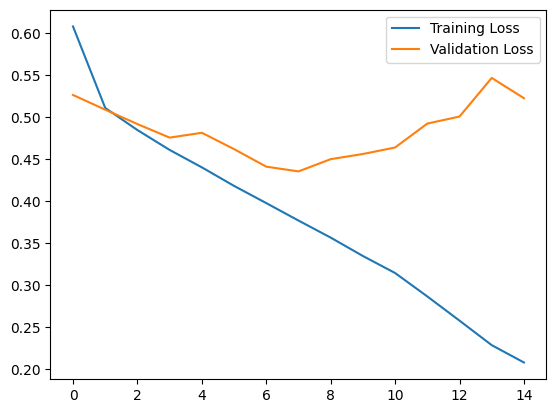

In [15]:
plt.plot(my_CNN_GPU_Drop.loss_during_training,label='Training Loss')
plt.plot(my_CNN_GPU_Drop.valid_loss_during_training,label='Validation Loss')
plt.legend()

print(my_CNN_GPU_Drop.eval_performance(trainloader))
print(my_CNN_GPU_Drop.eval_performance(validloader))

In [16]:
from sklearn.calibration import calibration_curve

def plot_reliability_diagram(y_true, y_prob, n_bins=10):
    # Obtain true prob and predicted prob
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='quantile')

    # Calculate ECE
    ece = ece_cal(y_prob, prob_true, prob_pred, n_bins)

    # Graph Reliability diagram
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=f'ECE = {ece:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Empirical Probability')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.grid()
    plt.show()

    return prob_true, prob_pred

def get_y_true_y_prob(model, test_loader, gpu=False):

    model.eval()

    # Initialize lists to store true labels and predicted probabilities
    y_true = []
    y_prob = []

    # Predict probabilities on the test set
    with torch.no_grad():
        for images, labels in test_loader:

            if gpu:
              images = images.to(model.device)
              labels = labels.to(model.device)

              outputs = model.forward(images)
              probabilities = (outputs)
              y_true.extend(labels.cpu().numpy())
              y_prob.extend(probabilities.cpu().numpy())

            else:
              outputs = model.forward(images)
              probabilities = (outputs)
              y_true.extend(labels.numpy())
              y_prob.extend(probabilities.numpy())

    return y_true, y_prob

def ece_cal(y_prob, prob_true, prob_pred, n_bins):
    final_ece = 0
    n = len(y_prob)

    # Iterarate over available bins in prob_true and prob_pred
    for m in range(len(prob_true)):
        # Tamaño del bin m
        bin_size = np.sum((y_prob >= prob_pred[m]) & (y_prob < prob_pred[m] + (1 / n_bins)))

        # Absolute difference bt true prob and predicted prob
        final_ece += np.abs(prob_true[m] - prob_pred[m]) * bin_size / n

    return final_ece




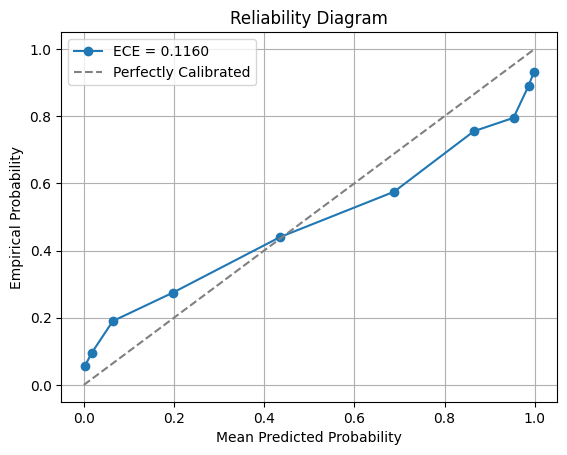

0.1159885008827382


In [17]:
y_true, y_prob = get_y_true_y_prob(my_CNN_GPU_Drop, testloader, gpu=True)
prob_true, prob_pred = plot_reliability_diagram(y_true, y_prob, n_bins=10)
ece = ece_cal(y_prob,prob_true, prob_pred, n_bins=10)
print(ece)


In [18]:
# For temperature scaling
def temperature_scaling(logits, temperature):
    # Usa softmax para obtener las probabilidades ajustadas
    scaled_probs = torch.sigmoid(logits / temperature)
    return scaled_probs

# apply_scaling using forward_logits()
def apply_scaling(model, test_loader, temperature, gpu=False):
    #Eval mode
    model.eval()
    # Store labels and scaled probs
    y_true = []
    scaled_probs = []

    # Predict logits test dataset
    with torch.no_grad():
        for images, labels in test_loader:

          if gpu:
              images = images.to(model.device)
              labels = labels.to(model.device)

              # Obtén los logits sin LogSoftmax
              logits = model.forward_logit(images)

              # Aplica temperature scaling
              scaled_probabilities = temperature_scaling(logits, temperature)

              # Guarda etiquetas verdaderas y probabilidades de la clase 0 (por ejemplo, "bird")
              y_true.extend(labels.cpu().numpy())
              scaled_probs.extend(scaled_probabilities.cpu().numpy()[:, 0])  # Probabilidad de la clase positiva 0

          else:
              # Logits without LogSoftmax
              logits = model.forward_logit(images)

              # Apply temperature scaling
              scaled_probabilities = temperature_scaling(logits, temperature)

              # Save labels and probs of class 0
              y_true.extend(labels.cpu().numpy())
              scaled_probs.extend(scaled_probabilities.cpu().numpy()[:, 0])  # Prob of class 0

    return y_true, scaled_probs


[0.1        0.21578947 0.33157895 0.44736842 0.56315789 0.67894737
 0.79473684 0.91052632 1.         1.02631579 1.14210526 1.25789474
 1.37368421 1.48947368 1.60526316 1.72105263 1.83684211 1.95263158
 2.06842105 2.18421053 2.3       ]

Temperature factor: 0.1


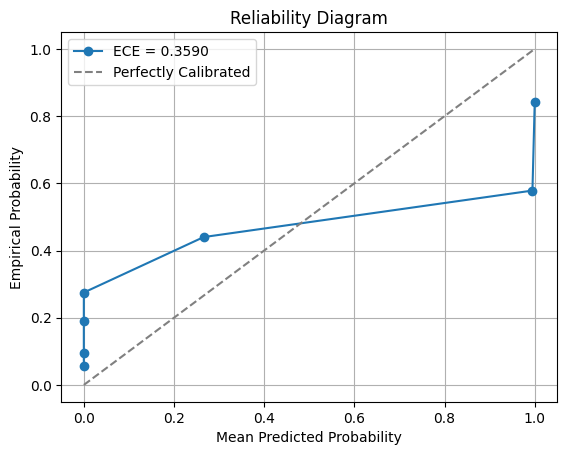

ECE: 0.35898086001636215


Temperature factor: 0.21578947368421053


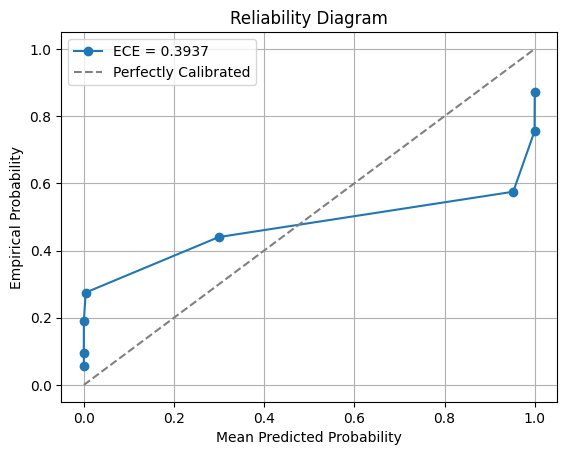

ECE: 0.39368251040240054


Temperature factor: 0.33157894736842103


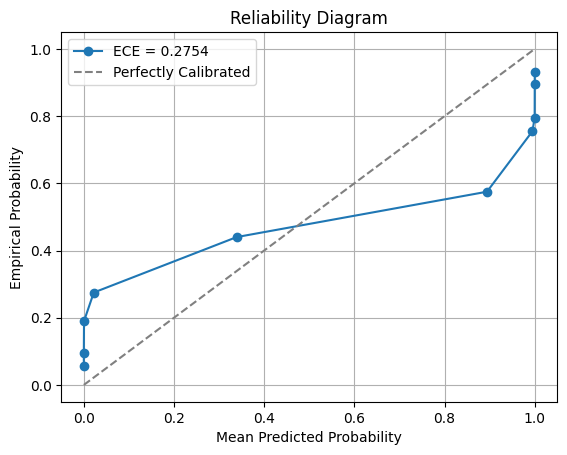

ECE: 0.27539127121659746


Temperature factor: 0.4473684210526315


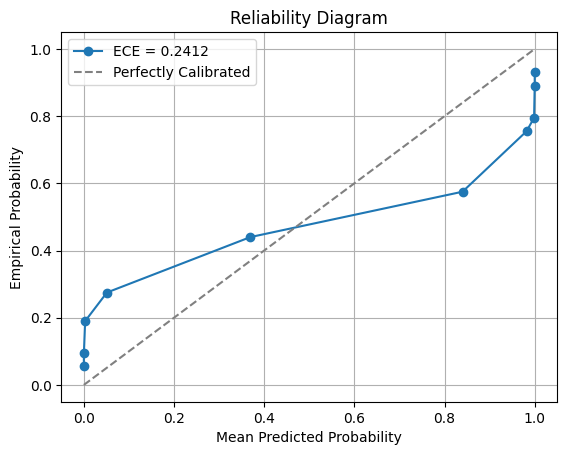

ECE: 0.2412401010348701


Temperature factor: 0.5631578947368421


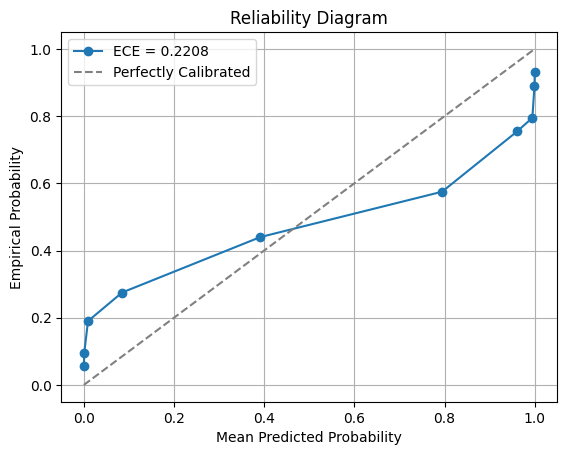

ECE: 0.22082238235219395


Temperature factor: 0.6789473684210525


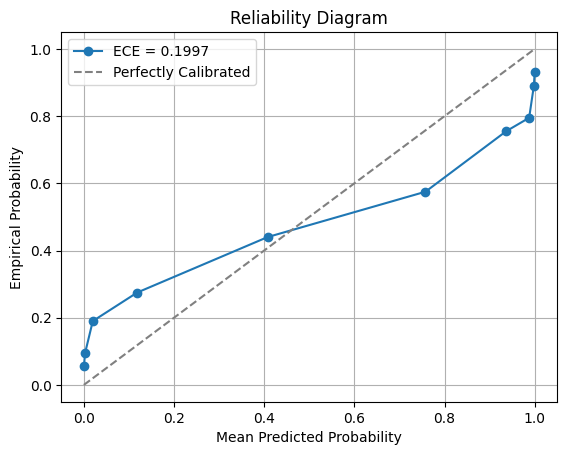

ECE: 0.19970812643501776


Temperature factor: 0.7947368421052631


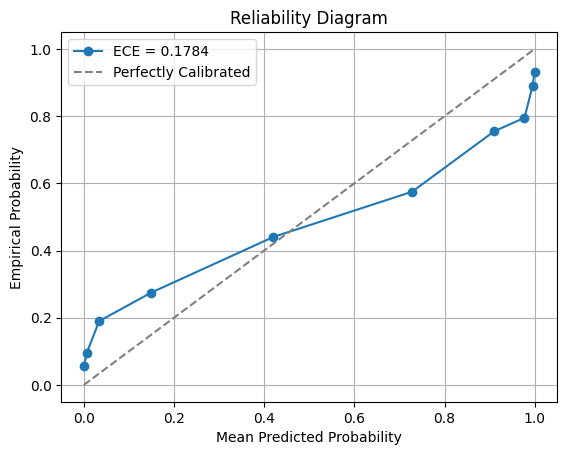

ECE: 0.1784244667722565


Temperature factor: 0.9105263157894735


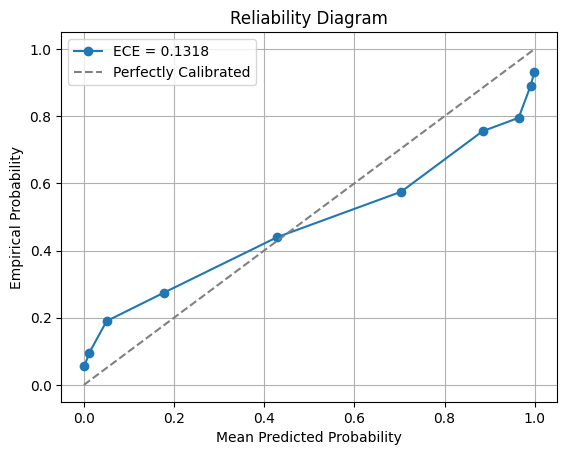

ECE: 0.13176407342868848


Temperature factor: 1.0


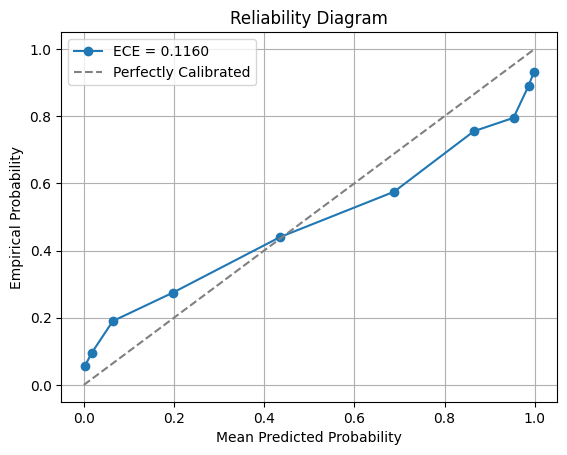

ECE: 0.1159885008827382


Temperature factor: 1.026315789473684


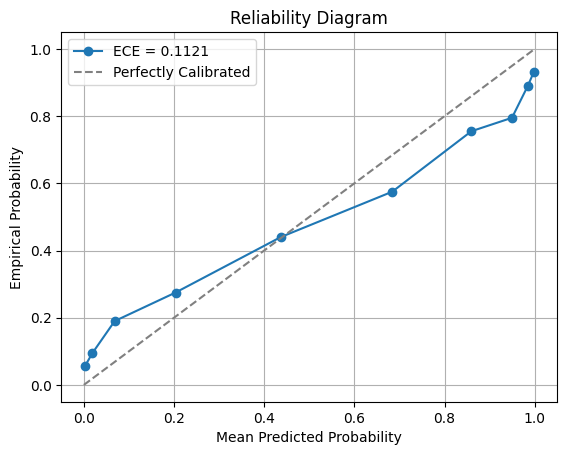

ECE: 0.11210425643233221


Temperature factor: 1.1421052631578947


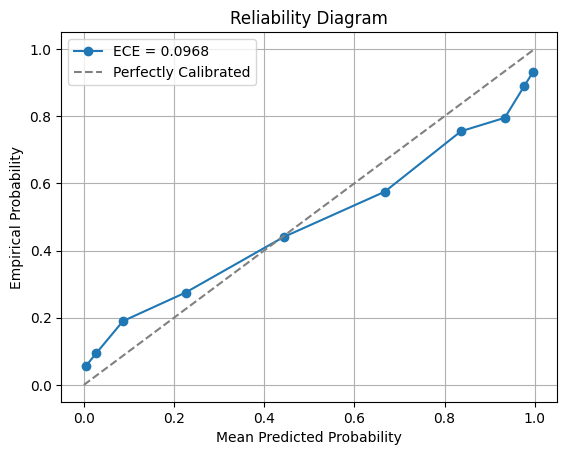

ECE: 0.09676711404719557


Temperature factor: 1.2578947368421052


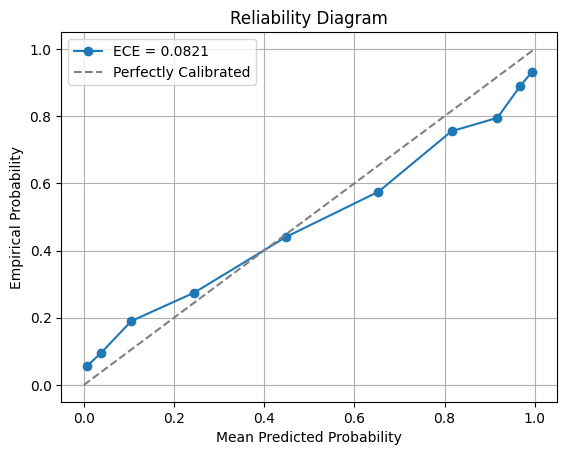

ECE: 0.08214758256155649


Temperature factor: 1.3736842105263156


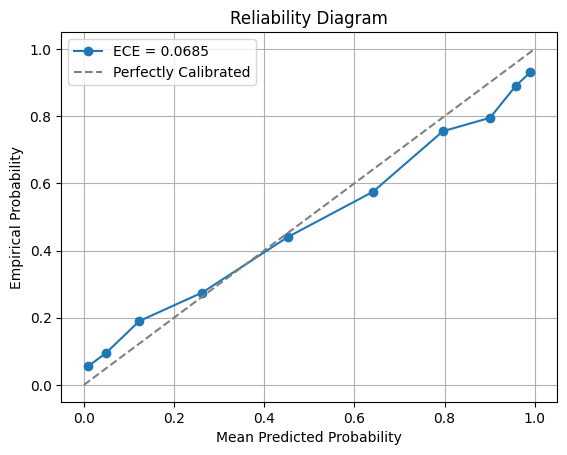

ECE: 0.06845347995770155


Temperature factor: 1.4894736842105263


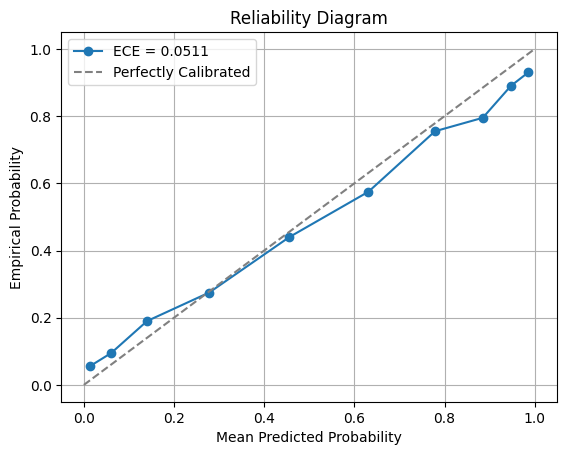

ECE: 0.051071040297349914


Temperature factor: 1.6052631578947367


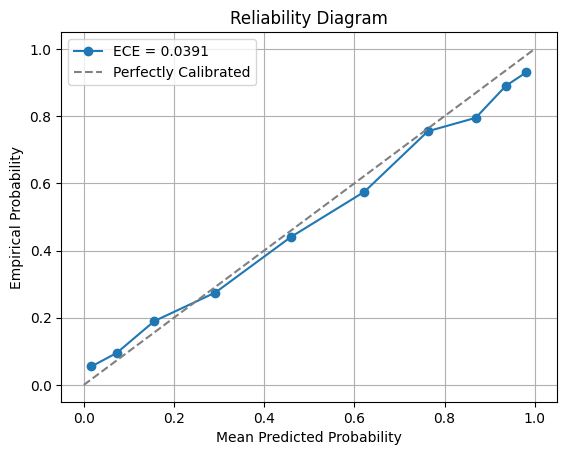

ECE: 0.03906602211852755


Temperature factor: 1.7210526315789472


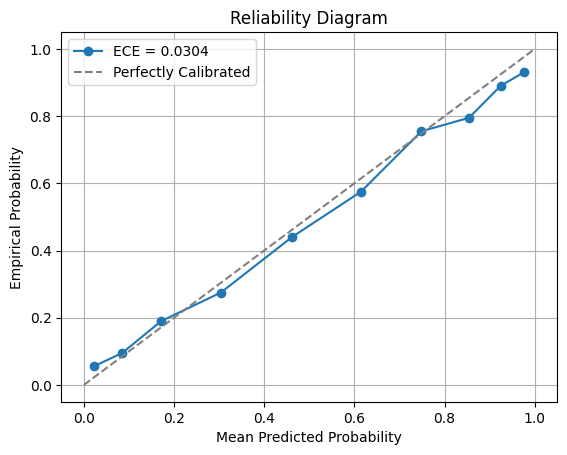

ECE: 0.03043281423171133


Temperature factor: 1.8368421052631578


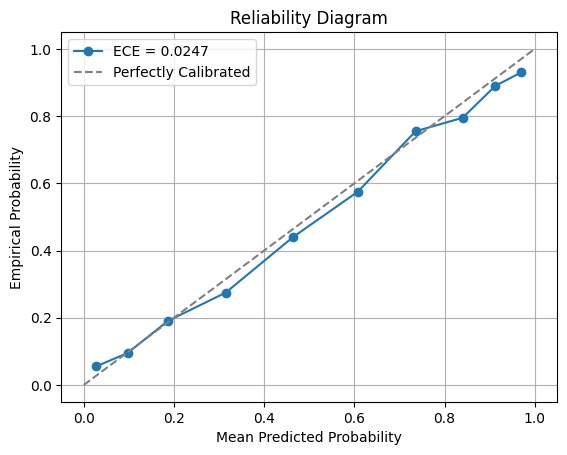

ECE: 0.02474279650647891


Temperature factor: 1.9526315789473683


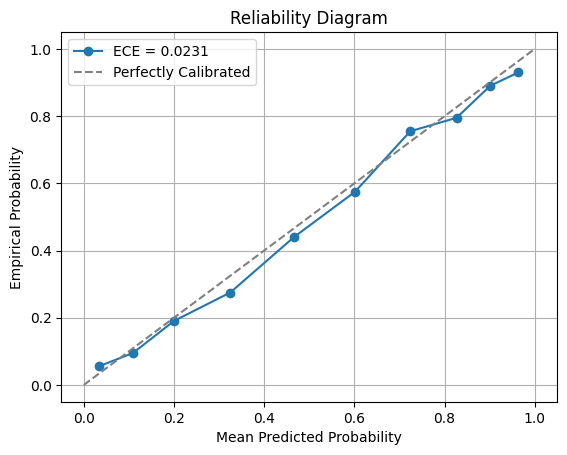

ECE: 0.023057729983082316


Temperature factor: 2.0684210526315785


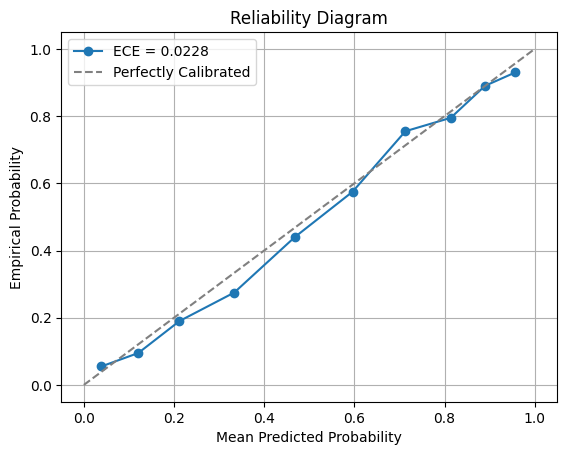

ECE: 0.022828894691969758


Temperature factor: 2.1842105263157894


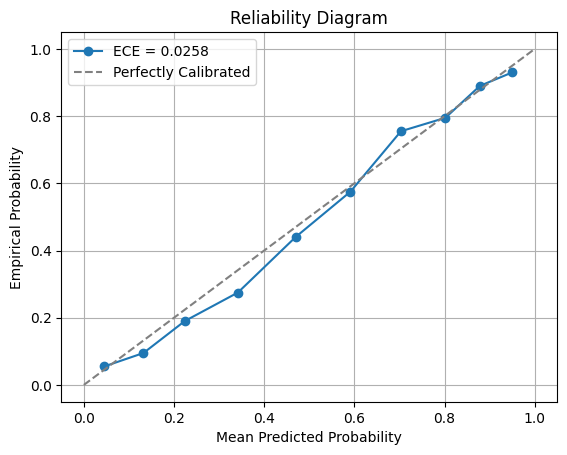

ECE: 0.025833935982561364


Temperature factor: 2.3


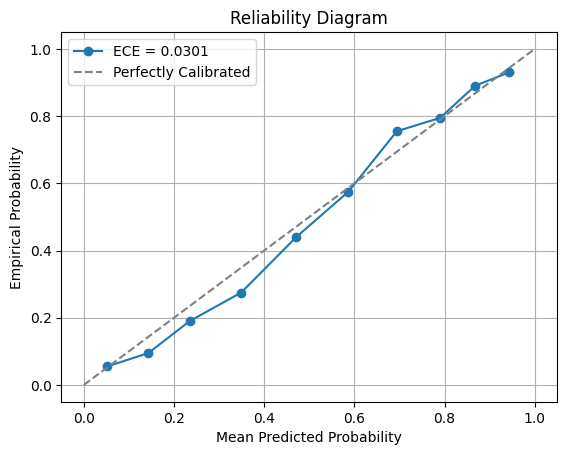

ECE: 0.030070892935404547



In [19]:
# Initialize dict to store results
results = {}

# Temp vector
temperatures = np.linspace(0.1, 2.3, 20)

# To find the index qhere the value 1 should be in the temperatures vector
index = np.searchsorted(temperatures, 1)

# Insert value 1 in the correct position
if temperatures[index] != 1:
    temperatures = np.insert(temperatures, index, 1)

print(temperatures)

#  Iterate over temperatures and save results in dict
for temp in temperatures:
    # Temp scaling
    y_true, scaled_probs = apply_scaling(my_CNN_GPU_Drop, testloader, temp, gpu=True)

    # Generate probs for reliability diagram
    print(f"\nTemperature factor: {temp}")
    prob_true, prob_pred = plot_reliability_diagram(y_true, scaled_probs, n_bins=10)

    #Calculate ECE (Expected Calibration Error)
    ece = ece_cal(scaled_probs, prob_true, prob_pred, n_bins=10)
    print(f"ECE: {ece}\n")

    # Save results in dict
    results[temp] = {
        "ECE": ece,
        "prob_true": prob_true,
        "prob_pred": prob_pred,
        "y_true": y_true,
        "scaled_probs": scaled_probs
    }




In [20]:
# Find Temp with the lowest (best) ECE
best_temp = None
best_ece = float('inf')

for temp, data in results.items():
    if data["ECE"] < best_ece:
        best_ece = data["ECE"]
        best_temp = temp

# Print results
print(f"Best ECE: {best_ece}")
print(f"Temperature for best ECE: {best_temp}")


Best ECE: 0.022828894691969758
Temperature for best ECE: 2.0684210526315785


In [21]:
# Print ECE for temperature 1
temp_1_ece = results.get(1, {}).get("ECE", None)

if temp_1_ece is not None:
    print(f"ECE for temperature = 1: {temp_1_ece}")
else:
    print("Temperature 1 hasn't been found in results.")


ECE for temperature = 1: 0.1159885008827382


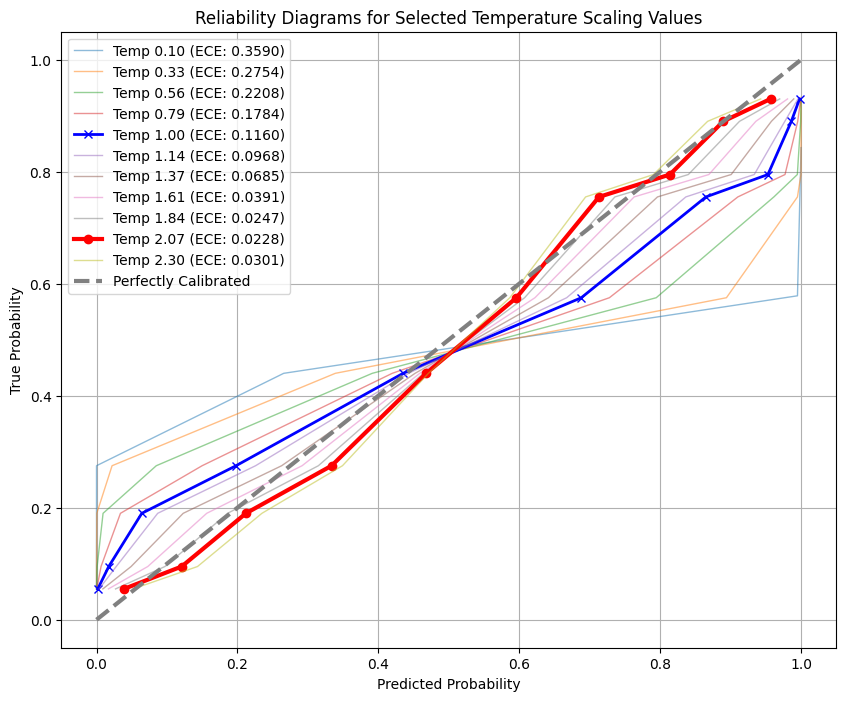

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Just take half of the temperatures
temps_to_plot = list(results.keys())
temps_to_plot.sort()

# Alternatively select temperatures and include best_temp and T=1
selected_temps = temps_to_plot[::2]  # Every two temperatures
if best_temp not in selected_temps:
    selected_temps.append(best_temp)
if 1 not in selected_temps:
    selected_temps.append(1)

# Plot lines
for temp, result in results.items():
    if temp in selected_temps:
        prob_true = result["prob_true"]
        prob_pred = result["prob_pred"]
        ece = result["ECE"]

        # Highlight the best
        if temp == best_temp:
            plt.plot(prob_pred, prob_true, marker='o', color='red', linewidth=3, label=f'Temp {temp:.2f} (ECE: {ece:.4f})')
        # Highilight T=1
        elif temp == 1:
            plt.plot(prob_pred, prob_true, marker='x', color='blue', linewidth=2, label=f'Temp {temp:.2f} (ECE: {ece:.4f})')
        # Make the rest thiner
        else:
            plt.plot(prob_pred, prob_true, marker='', linewidth=1, alpha=0.5, label=f'Temp {temp:.2f} (ECE: {ece:.4f})')

#Plot line reference for perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=3, label='Perfectly Calibrated')

plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Reliability Diagrams for Selected Temperature Scaling Values")
plt.legend()
plt.grid()
plt.show()


In [ ]:
#@title Extra Point
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import time
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models

model_extra = models.densenet121(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

# Train Set
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# Test Set
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_subset.transform = train_transforms
valid_subset.transform = test_transforms
testset.transform = test_transforms

# Create data loaders for train, validation, and test sets with data augmentation transformations
train_loader_extra = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
val_loader_extra = torch.utils.data.DataLoader(valid_subset, batch_size=64, shuffle=False, num_workers=2)
test_loader_extra = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

print(f"Train size: {len(train_subset)}, Validation size: {len(valid_subset)}, Test size: {len(testset)}")

Train size: 8000, Validation size: 2000, Test size: 2000


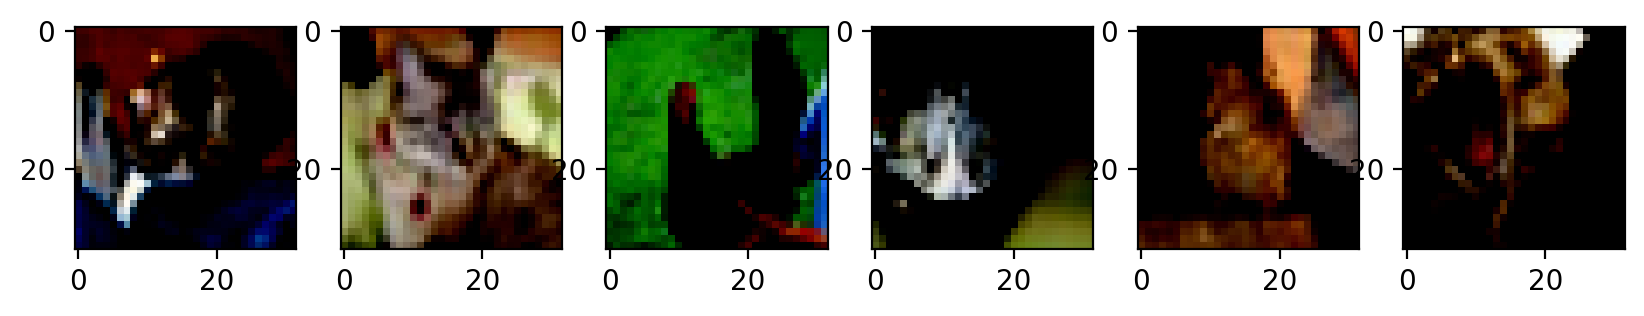

In [ ]:
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=6)
for ii in range(6):
    ax = axes[ii]
    ax.imshow(images[ii,:,:,:].numpy().transpose((1,2,0)))

In [ ]:
class MLP(nn.Module):
    def __init__(self,dimx=1024,hidden=500,nlabels=2):

        super().__init__()

        self.output1 = nn.Linear(dimx,hidden)

        self.output2 = nn.Linear(hidden,nlabels)

        self.relu = nn.ReLU()

        self.logsoftmax = nn.LogSoftmax()

    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.logsoftmax(x)
        return x

In [ ]:
# Freeze parameters so we don't backprop through them
for param in model_extra.parameters():
    param.requires_grad = False

classifier = MLP(1024)

model_extra.classifier = classifier

In [ ]:
class Tran_Eval():


    def __init__(self,model,maxiter=500,lr=0.001):

        self.model = model

        self.lr = lr #Learning Rate

        self.optim = optim.Adam(self.model.classifier.parameters(), self.lr)

        self.max_iter = maxiter

        self.criterion = nn.NLLLoss()

        # A list to store the loss evolution along training

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model.to(self.device)

    def trainloop(self,trainloader):

        # Optimization Loop

        it_images = iter(trainloader)

        running_loss = 0.

        self.model.train()

        for e in range(int(self.max_iter)):


            images,labels = next(it_images)


            # Move input and label tensors to the default device
            images, labels = images.to(self.device), labels.to(self.device)

            self.optim.zero_grad()  #TO RESET GRADIENTS!

            out = self.model.forward(images)


            loss = self.criterion(out,labels)

            running_loss = loss.item()


            loss.backward()


            self.optim.step()

            self.loss_during_training.append(running_loss)

            print('Batch %d of %d finished. Loss %f' %(e,self.max_iter,running_loss))


    def eval_performance(self,dataloader,num_batches):

        accuracy = 0

        it_images = iter(dataloader)

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            self.model.eval()

            for e in range(int(num_batches)):

                print('Batch %d of %d' %(e,num_batches))

                images,labels = next(it_images)

                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)
                probs = self.model.forward(images)

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        return accuracy/num_batches

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Batch 0 of 10 finished. Loss 0.702545
Batch 1 of 10 finished. Loss 0.729667
Batch 2 of 10 finished. Loss 0.674032
Batch 3 of 10 finished. Loss 0.712526
Batch 4 of 10 finished. Loss 0.713508
Batch 5 of 10 finished. Loss 0.649914
Batch 6 of 10 finished. Loss 0.593834
Batch 7 of 10 finished. Loss 0.614244
Batch 8 of 10 finished. Loss 0.707702
Batch 9 of 10 finished. Loss 0.576477


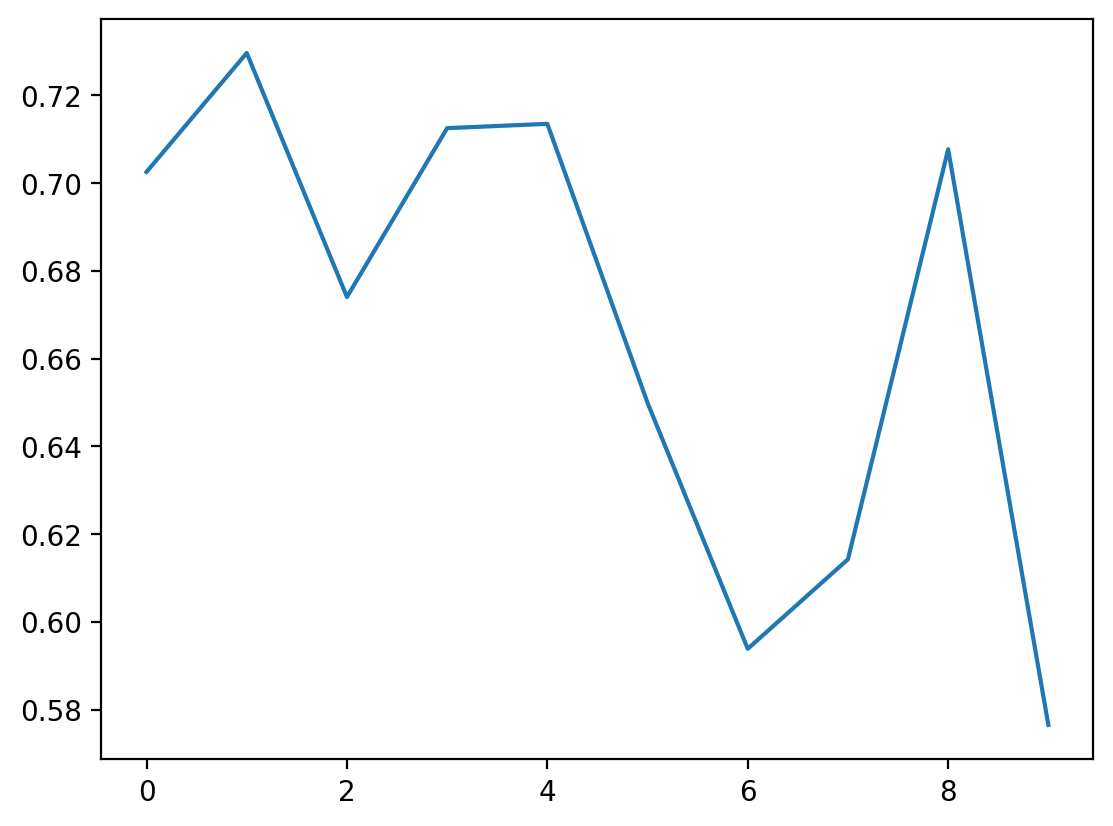

In [ ]:
model_with_train = Tran_Eval(model_extra,maxiter=10)

model_with_train.trainloop(train_loader_extra)

plt.plot(model_with_train.loss_during_training)

In [ ]:
def get_y_true_y_prob_2(model, test_loader):

    model.eval()

    model.cpu()

    # Initialize lists to store true labels and predicted probabilities
    y_true = []
    y_prob = []

    # Predict probabilities on the test set
    with torch.no_grad():
        for images, labels in test_loader:


            outputs = model.forward(images)
            probabilities = nn.functional.softmax(outputs, dim = 1)
            y_true.extend(labels.numpy())
            y_prob.extend(probabilities.numpy()[:,0])

    return y_true, y_prob

In [ ]:
# Slightly modified for this new case
def plot_reliability_diagram_2(y_true, y_prob, n_bins=10):
    # Obtain predicted prob and true prob
    prob_true, prob_pred = calibration_curve(y_true, y_prob, pos_label = 0)

    # Calcular el ECE
    ece = ece_cal(y_prob, prob_true, prob_pred, n_bins)

    #Reliability diagram
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=f'ECE = {ece:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')


    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Empirical Probability')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.grid()
    plt.show()

    return prob_true, prob_pred

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


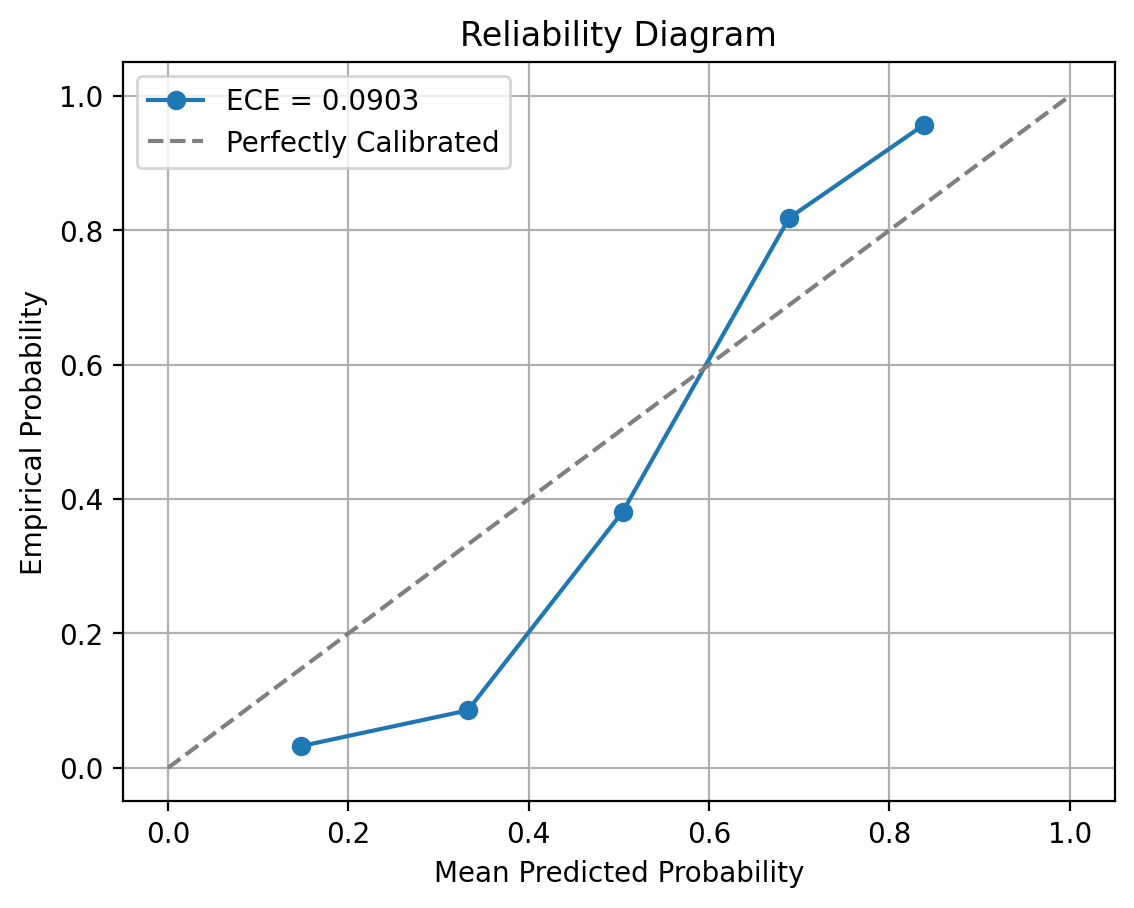

0.09029292700512787


In [ ]:
y_true_extra, y_prob_extra = get_y_true_y_prob_2(model_with_train.model, test_loader_extra)
prob_true_extra, prob_pred_extra = plot_reliability_diagram_2(y_true_extra, y_prob_extra, n_bins=10)
ece_extra = ece_cal(y_prob_extra,prob_true_extra, prob_pred_extra, n_bins=10)
print(ece_extra)

In [ ]:
# Modified for softmax function
def temperature_scaling_2(logits, temperature):
    # Usa softmax para obtener las probabilidades ajustadas
    scaled_probs = torch.nn.functional.softmax(logits / temperature)
    return scaled_probs


In [ ]:
# Modified for this new case
def apply_scaling_mod(model, test_loader, temperature):

    # Eval mode
    model.eval()

    model.cpu()

    # Initialize labels and scaled_probs
    y_true = []
    scaled_probs = []

    # Predict logits in test dataset
    with torch.no_grad():
        for images, labels in test_loader:


            logits = model(images)
            scaled_probabilities = temperature_scaling(logits, temperature)

            #Save true labels and probs of class 0
            y_true.extend(labels.cpu().numpy())
            scaled_probs.extend(scaled_probabilities.cpu().numpy()[:, 0])  # Probs of class 0

    return y_true, scaled_probs



In [ ]:
# Initialize dict to store results
results = {}

# Temp vector
temperatures = np.linspace(0.1, 2.3, 20)

# To find the index qhere the value 1 should be in the temperatures vector
index = np.searchsorted(temperatures, 1)

# Insert value 1 in the correct position
if temperatures[index] != 1:
    temperatures = np.insert(temperatures, index, 1)

print(temperatures)

#  Iterate over temperatures and save results in dict
for temp in temperatures:
    # Temp scaling
    y_true, scaled_probs = apply_scaling_mod(model_extra, testloader, temp)

    # Generate probs for reliability diagram
    print(f"\nTemperature factor: {temp}")
    prob_true, prob_pred = plot_reliability_diagram_2(y_true, scaled_probs, n_bins=10)

    #Calculate ECE (Expected Calibration Error)
    ece = ece_cal(scaled_probs, prob_true, prob_pred, n_bins=10)
    print(f"ECE: {ece}\n")

    # Save results in dict
    results[temp] = {
        "ECE": ece,
        "prob_true": prob_true,
        "prob_pred": prob_pred,
        "y_true": y_true,
        "scaled_probs": scaled_probs
    }




Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Find Temp with the lowest (best) ECE
best_temp = None
best_ece = float('inf')

for temp, data in results.items():
    if data["ECE"] < best_ece:
        best_ece = data["ECE"]
        best_temp = temp

# Print results
print(f"Best ECE: {best_ece}")
print(f"Temperature for best ECE: {best_temp}")

Best ECE: 0.04304910785829393
Temperature for best ECE: 0.4473684210526315


In [ ]:
#Print ECE for temperature 1
temp_1_ece = results.get(1, {}).get("ECE", None)

if temp_1_ece is not None:
    print(f"ECE para temperatura = 1: {temp_1_ece}")
else:
    print("La temperatura 1 no está en los resultados.")


ECE para temperatura = 1: 0.09029292700512787


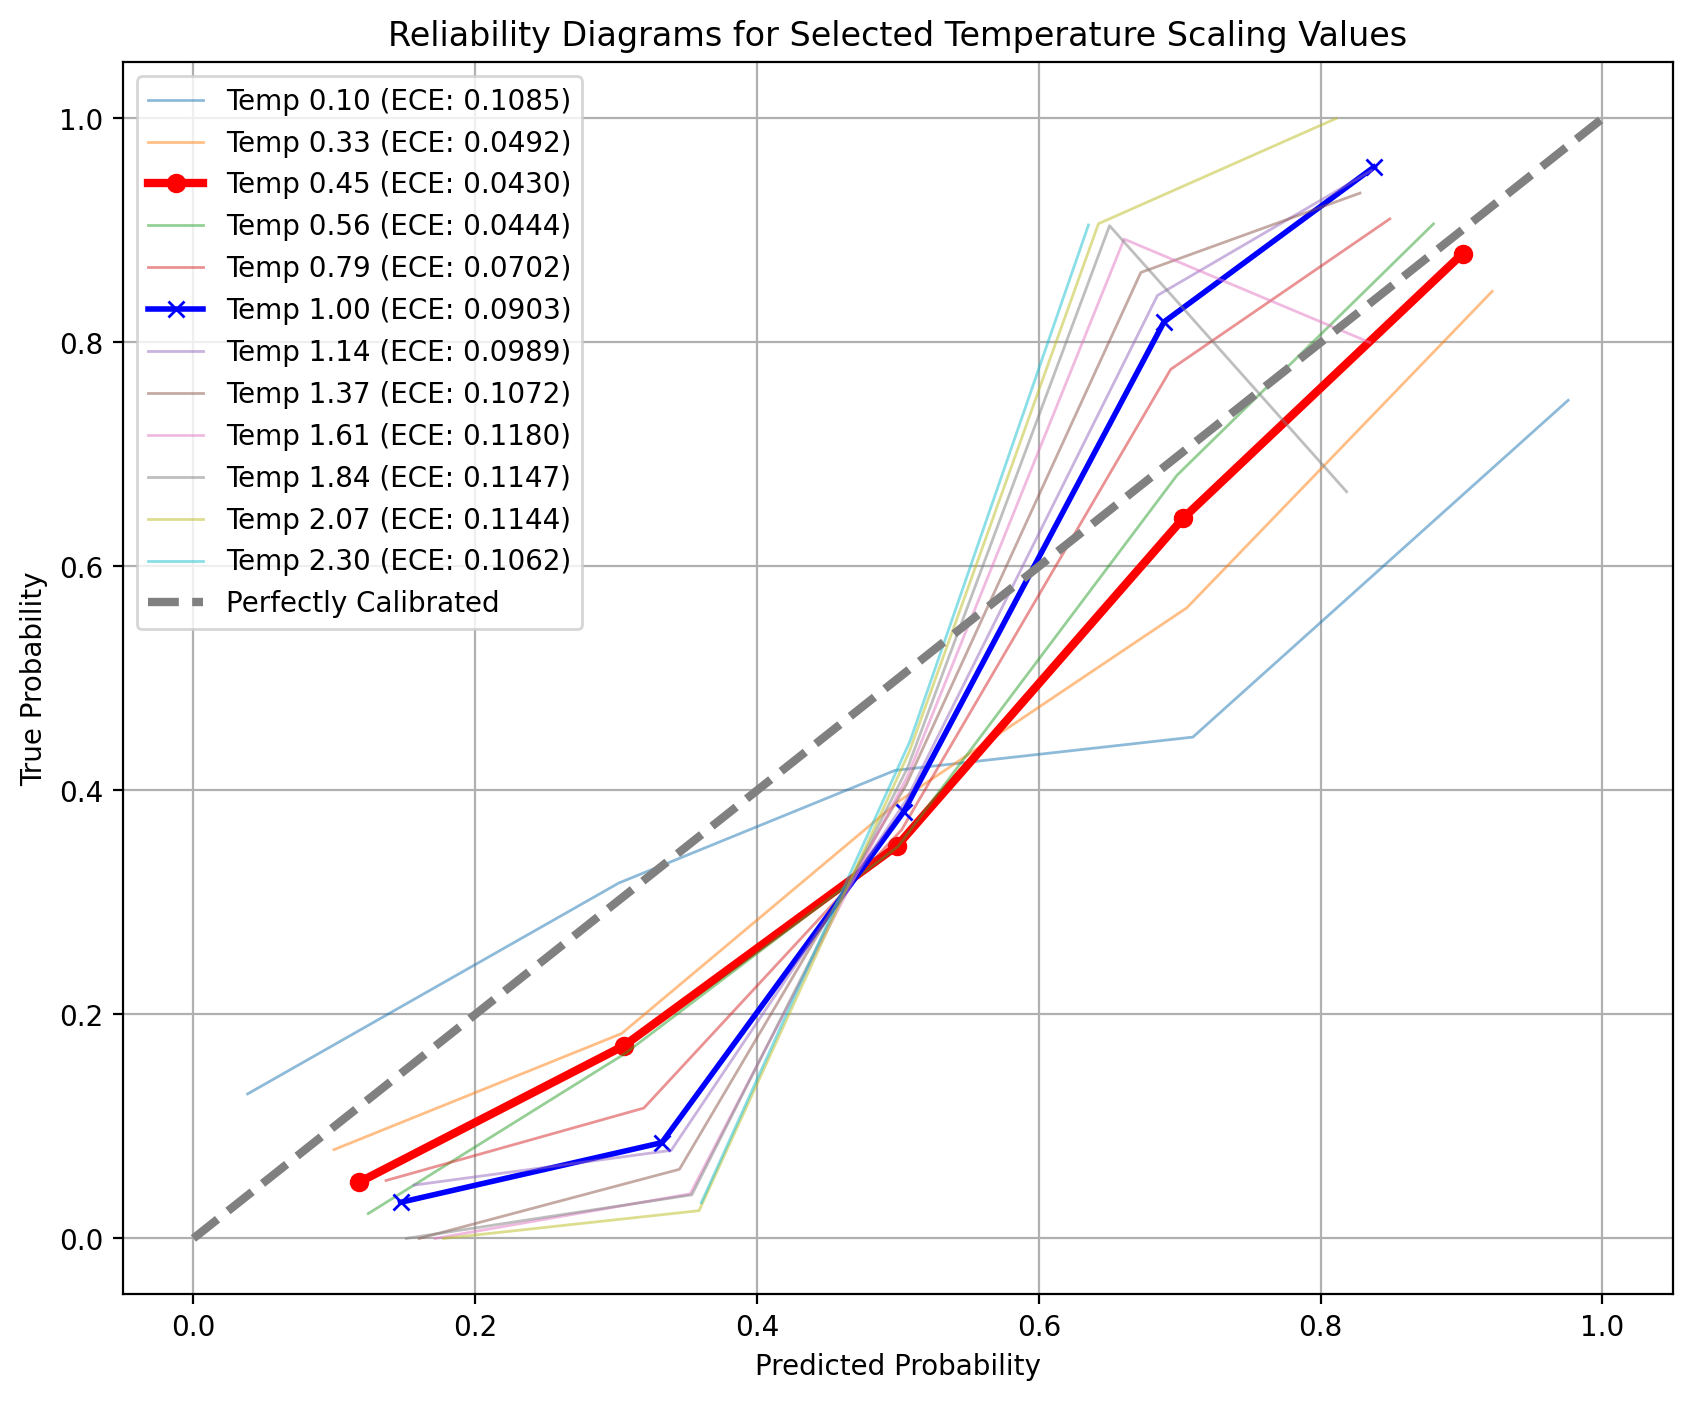

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Just take half of the temperatures
temps_to_plot = list(results.keys())
temps_to_plot.sort()

# Alternatively select temperatures and include best_temp and T=1
selected_temps = temps_to_plot[::2]  # Every two temperatures
if best_temp not in selected_temps:
    selected_temps.append(best_temp)
if 1 not in selected_temps:
    selected_temps.append(1)

# Plot lines
for temp, result in results.items():
    if temp in selected_temps:
        prob_true = result["prob_true"]
        prob_pred = result["prob_pred"]
        ece = result["ECE"]

        # Highlight the best
        if temp == best_temp:
            plt.plot(prob_pred, prob_true, marker='o', color='red', linewidth=3, label=f'Temp {temp:.2f} (ECE: {ece:.4f})')
        # Highilight T=1
        elif temp == 1:
            plt.plot(prob_pred, prob_true, marker='x', color='blue', linewidth=2, label=f'Temp {temp:.2f} (ECE: {ece:.4f})')
        # Make the rest thiner
        else:
            plt.plot(prob_pred, prob_true, marker='', linewidth=1, alpha=0.5, label=f'Temp {temp:.2f} (ECE: {ece:.4f})')

#Plot line reference for perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=3, label='Perfectly Calibrated')

plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Reliability Diagrams for Selected Temperature Scaling Values")
plt.legend()
plt.grid()
plt.show()
